# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# magic word for producing visualizations in notebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 12

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
(n_records, n_features) = azdias.shape
print(f"No. of records: {n_records}, No. of features: {n_features}")

# Display DF head
display(azdias.head())

No. of records: 891221, No. of features: 85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
display(feat_info.head())
print(f"Information level:\n {feat_info['information_level'].unique()}")
print(f"Data type\n {feat_info['type'].unique()}")

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


Information level:
 ['person' 'household' 'building' 'microcell_rr4' 'microcell_rr3'
 'postcode' 'region_rr1' 'macrocell_plz8' 'community']
Data type
 ['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
import re

def parse_missing_val(string):
    """
    Function to parse missing values from str to list and record in dictopnary
    """
    m = re.search(r'\[(.+)\]', string) #everything within []
    if m:
        k = m.group(1).split(',')
        l = []
        for i in k:
            try:
                l.append(int(i)) # foe numbers
            except:
                l.append(i) #for str 'X'

        return dict(zip(l,np.tile(np.NAN,len(l))))
    else:
        return dict()

In [6]:
# Get missing value codes and record in dictionary
feat_info['dict_missing_or_unknowns'] = feat_info['missing_or_unknown'].map(parse_missing_val)

# Transform all missing value codes to NAN
for col in azdias.columns:
    dict_nan = feat_info.loc[(feat_info['attribute'] == col),'dict_missing_or_unknowns'].item()
    azdias[col] = azdias[col].map(lambda x: dict_nan[x] if x in dict_nan.keys() else x)

# Double check if missing values are transformed to Nans
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

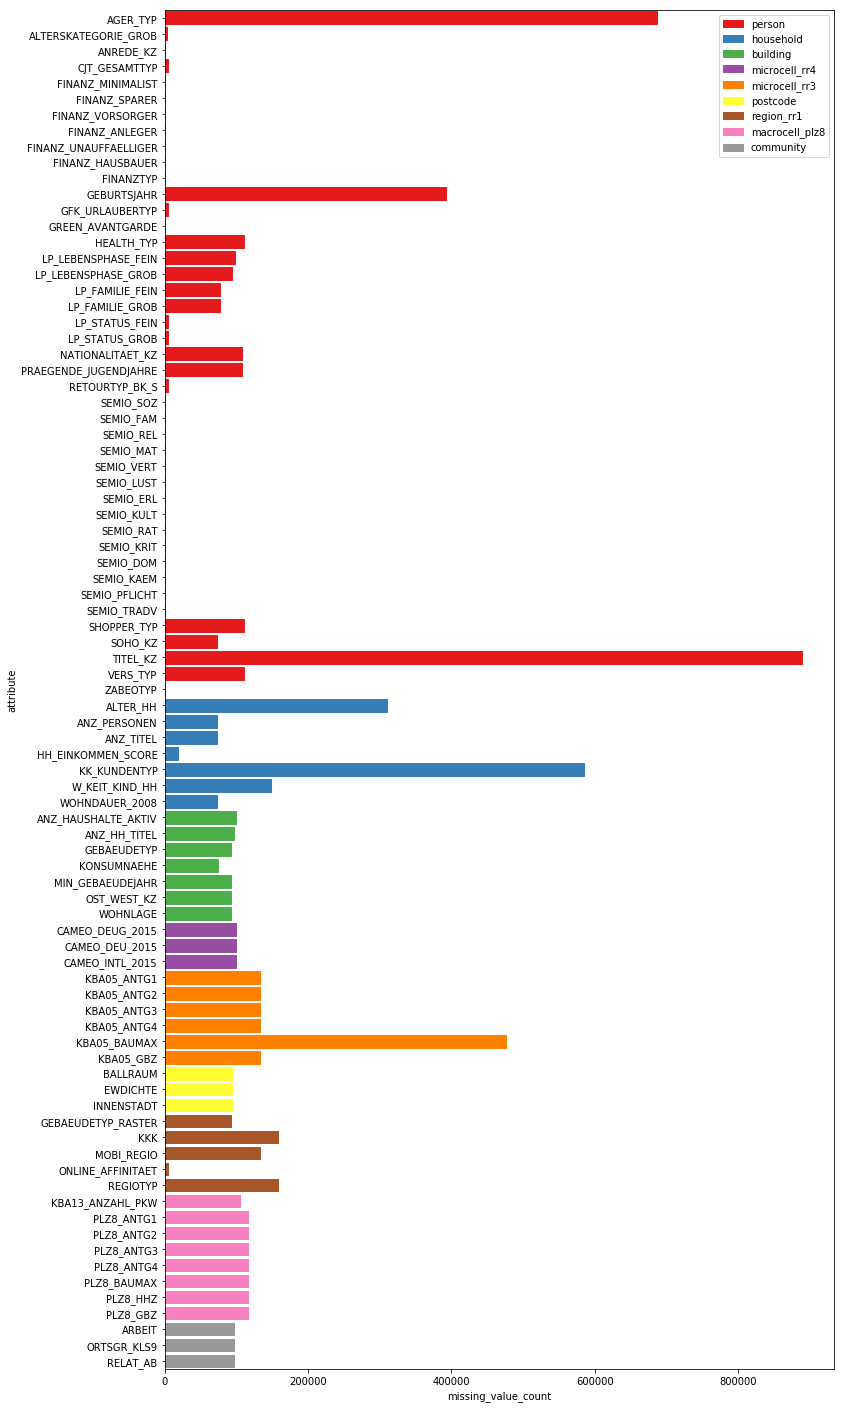

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

feat_info['missing_value_count'] = azdias.isnull().sum().values

# Plotting
plt.figure(figsize = (12,25));
barlist = sns.barplot(data = feat_info, y = 'attribute', x = 'missing_value_count');

# Generate bar colours by information level
information_level = list(feat_info['information_level'].unique())
n_information_level = len(information_level)

barcolors = sns.color_palette('Set1', n_colors=n_information_level);

dict_bar_colors = dict(zip(information_level, barcolors))
feat_info['information_level_color'] = feat_info['information_level'].map(dict_bar_colors)

for i in range(n_features):
    barlist.get_children()[i].set_color(feat_info.loc[i,'information_level_color']) 

# Generate legends
idx,label = [],[]
for s in information_level:
    idx.append(barlist.get_children()[feat_info[feat_info['information_level'] == s].index[0]])
    label.append(s)
    
barlist.legend(idx,label);

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
idx_outlier = feat_info['missing_value_count']>300000
outlier = feat_info[idx_outlier].attribute

azdias_nancol_removed = azdias.drop(outlier, axis=1)
feat_info_nancol_removed = feat_info.drop(outlier.index)

print(f'Columns removed: {list(outlier)}')

Columns removed: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


### Discussion 1.1.2: Assess Missing Data in Each Column

In general, the amount of missing data ranges fromm 10 - 15% across all information level, with personal level haveing the least amount of missing data in most of the features. 
'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX' are the outliers in this regard, with 'TITEL_KZ' having almost 100% missing data. The other ouliers generally have more than 30% missing data. I used missing data > 300000 as a cutoff to remove these outliers.<br>
The remaining features showed an interesing pattern that most of the features within the same information level share the same amount of missing values and some numbers of missing data are repeatedly found. It could be a result of implementing the data collection procedures a number of times within the same population at different timepoints so that some participants were no longer available to give complete information. This may be better illustrated when the missing data within rows is considered.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

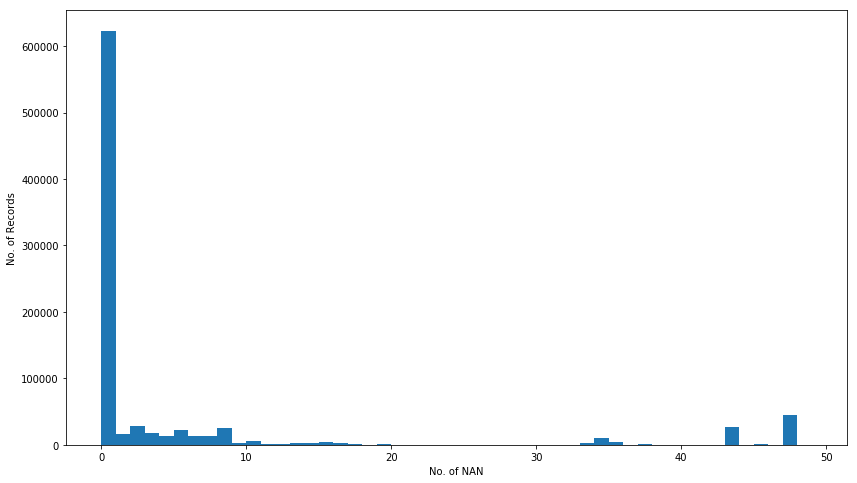

In [9]:
# How much data is missing in each row of the dataset?
miss_by_row = azdias_nancol_removed.isnull().sum(axis=1)

plt.figure(figsize = (14,8))
plt.hist(miss_by_row, bins = range(50));
plt.xlabel('No. of NAN');
plt.ylabel('No. of Records');

In [10]:
pd.DataFrame(pd.qcut(miss_by_row, 50, duplicates='drop').value_counts(sort=False)/len(miss_by_row)).transpose()

,"(-0.001, 1.0]","(1.0, 2.0]","(2.0, 3.0]","(3.0, 4.0]","(4.0, 5.0]","(5.0, 6.0]","(6.0, 8.0]","(8.0, 13.0]","(13.0, 34.0]","(34.0, 43.0]","(43.0, 47.0]","(47.0, 49.0]"
0,0.716934,0.031335,0.019781,0.014146,0.025263,0.015452,0.042981,0.01526,0.030044,0.036931,0.051869,0.000003


### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of No. of missing data in each row showed that the majority of data has no missing value. <br>
Cutting the data into 20 quartiles(5% each) reveals that over 70% of data has no missing value, around 9% contains 1-5 missing value, 6% contains 5-8 missing value, 4.5% contains 8-34 missing value and 3.5% contains 34-43 missing values and 5% contains >43 missing values. A selection of threhold around 9 - 34 will retain around 90% of data.

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
def compare_nan_subsets(df, ncol, threshold, threshold2 = 8, random=False):    
    
    r_miss = miss_by_row >= threshold
    r_mid = (miss_by_row < threshold) & (miss_by_row >= threshold2)
    r_good = miss_by_row < threshold2
    
    # Plot only data with few missing balues
    idx_low_nan = df.isnull().sum(axis=0) < 100
    features = list(df.loc[:,idx_low_nan].columns)
    n_features = len(features)
    features_to_plot = [0,5,7,9,20]
    if random:
        features_to_plot = np.random.randint(0, n_features, size = ncol)
    
    # Create y-labels
    y_label = [f'Missing Value < {threshold2}',
               f' {threshold2} < Missing Value < {threshold}',
               f'Missing Value >= {threshold}']  
    
    fig, ax = plt.subplots(3, ncol, sharex= False, figsize = (18,12))

    for j, idx in enumerate(features_to_plot):
        for i, rows in enumerate([r_good, r_mid, r_miss]):
            try:
                sns.countplot(data = df.loc[rows, idx_low_nan], x = features[idx], ax = ax[i][j])
                ax[i][j].autoscale(axis = 'x')
            except:
                print(f'No data found in column \'{features[idx]}\' for the NaN subject dataset!')
                
            if j == 0:
                ax[i][0].set_ylabel(y_label[i])

    plt.tight_layout()

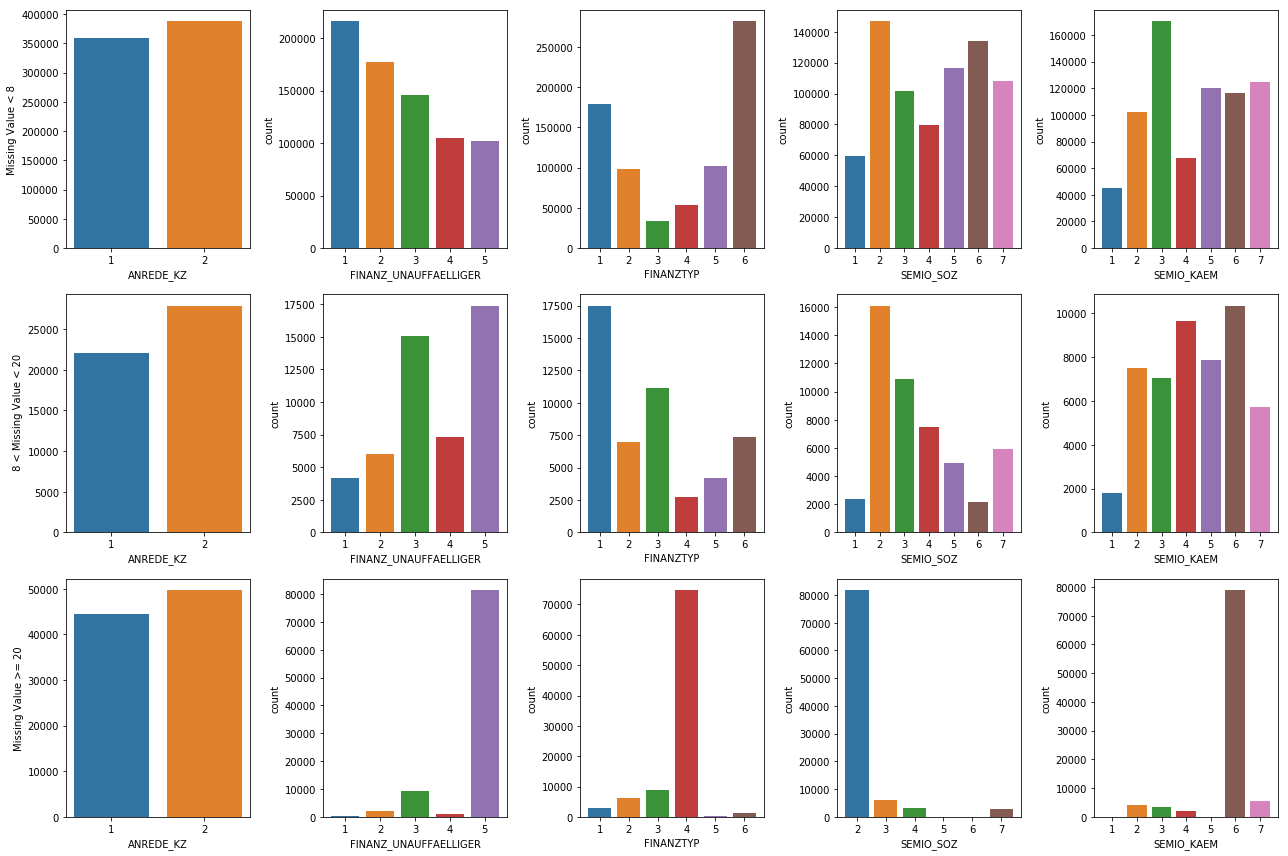

In [15]:
compare_nan_subsets(azdias_nancol_removed, ncol = 5, threshold = 20) 

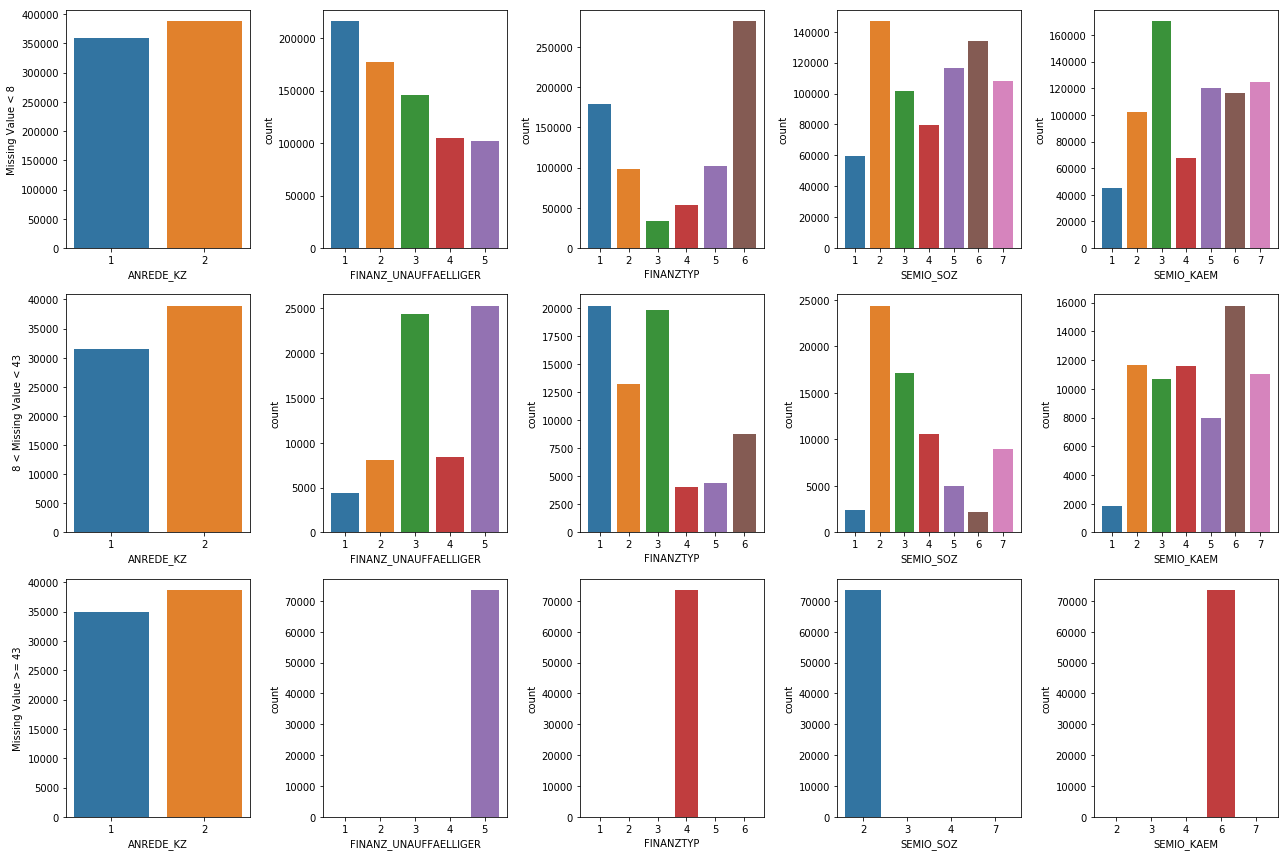

In [16]:
compare_nan_subsets(azdias_nancol_removed, ncol = 5, threshold = 43) 

### Discussion 1.1.3.2: Assess Missing Data in Each Row

From the subplots above, it is clear that there is an abmormally high amount of 1 particular value (e.g., 5 in FINANZ_UNAUFFAELLIGER, 4 in FINANZTYP) in the lowest row (subset with no. of missing data above threshold).
The data with missing values within 8 - 20 showed a somewhat normal distribution matching with the distribution in the good data with missing value < 8. <br>
However, with the subset with missing data > 20 showed a mono distribution where 1 particular value dominates the whole distribution. It is noted that the subset with >= 20 missing values still possess a number of counts of the values other than the dominated one (the signal) while the subset with >= 43 missing values contains purely noise. This could be some sort of default value, a change in execution of data collection process, or the participants were too disengaged to give accurate answers.

Although there are still signals in data with high proportion of missing value before reaching the ultimate threshold of 43, 20 is selected as the threshold here to leave a safety margin as retaining such a large amount of records with high count of missing data may create bias and muddle the data.

In the following analysis, only the good data (missing value =< 20) are used, and thus, 90% of the total data are retained.

Those with >= 20 missing values are quantitatively different from the other data and will be revisited at the end of the analysis.

In [18]:
row_good = miss_by_row <= 20
azdias_good = azdias_nancol_removed[row_good]

(n_record_good, n_feature_good) = azdias_good.shape
print(f"Before removing the corrupted data: \n   No. of records: {n_records}, No, of features: {n_features} \n")
print(f"After removing the corrupted data: \n   No. of records: {n_record_good}, No, of features: {n_feature_good}")

Before removing the corrupted data: 
   No. of records: 891221, No, of features: 85 

After removing the corrupted data: 
   No. of records: 797426, No, of features: 79


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info_nancol_removed['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

In [20]:
# Dataframe for ordinal features
idx_ordinal = feat_info_nancol_removed['type'] == 'ordinal'
col_ordinal = feat_info_nancol_removed[idx_ordinal].attribute
azdias_ordinal = azdias_good.loc[:,col_ordinal]

# Dataframe for numric features
idx_numeric = feat_info_nancol_removed['type'] == 'numeric'
col_numeric = feat_info_nancol_removed[idx_numeric].attribute
azdias_numeric = azdias_good.loc[:,col_numeric]

# DataFrame for binary, categorical and mixed features, see below

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
idx_categorical = feat_info_nancol_removed['type'] == 'categorical'
col_categorical = feat_info_nancol_removed[idx_categorical].attribute

azdias_binary = pd.DataFrame()
azdias_cat = pd.DataFrame()

for key in col_categorical:
    code = azdias_good.dropna()[key].unique()
    try:
        code_ordered = np.sort(code)
    except: 
        code_ordered = code
    finally:
        print(f"Attribute: {key}\nCode: {code_ordered}")
        if (len(code) <= 2):
            azdias_binary[key] = azdias_good[key]
        else:
            azdias_cat[key] = azdias_good[key]

Attribute: ANREDE_KZ
Code: [1 2]
Attribute: CJT_GESAMTTYP
Code: [1. 2. 3. 4. 5. 6.]
Attribute: FINANZTYP
Code: [1 2 3 4 5 6]
Attribute: GFK_URLAUBERTYP
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Attribute: GREEN_AVANTGARDE
Code: [0 1]
Attribute: LP_FAMILIE_FEIN
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Attribute: LP_FAMILIE_GROB
Code: [1. 2. 3. 4. 5.]
Attribute: LP_STATUS_FEIN
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Attribute: LP_STATUS_GROB
Code: [1. 2. 3. 4. 5.]
Attribute: NATIONALITAET_KZ
Code: [1. 2. 3.]
Attribute: SHOPPER_TYP
Code: [0. 1. 2. 3.]
Attribute: SOHO_KZ
Code: [0. 1.]
Attribute: VERS_TYP
Code: [1. 2.]
Attribute: ZABEOTYP
Code: [1 2 3 4 5 6]
Attribute: GEBAEUDETYP
Code: [1. 3. 5. 8.]
Attribute: OST_WEST_KZ
Code: ['O' 'W']
Attribute: CAMEO_DEUG_2015
Code: ['1' '2' '3' '4' '5' '6' '7' '8' '9']
Attribute: CAMEO_DEU_2015
Code: ['1A' '1B' '1C' '1D' '1E' '2A' '2B' '2C' '2D' '3A' '3B' '3C' '3D' '4A'
 '4B' '4C' '4D' '4E' '5A' '5B' '5C' '5D' '5E' '5F

In [22]:
# CAMEO_DEUG_2015 actually has an ordinal meaning from lower class to upper class,
# and is reassigned to ordinal DataFrame
azdias_ordinal['CAMEO_DEUG_2015'] = azdias_cat['CAMEO_DEUG_2015']
azdias_cat.drop('CAMEO_DEUG_2015', axis=1, inplace=True)

In [23]:
# Record Updated Categorical and Binary Columns for Later Useage
col_cat = azdias_cat.columns
col_binary = azdias_binary.columns

### Re-encode Binary Features

In [24]:
# Check Cols with binary variables
azdias_binary.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [25]:
# Re-encode binary variables
idx = azdias_good['OST_WEST_KZ'].dropna().index
azdias_binary['OST_WEST_KZ'] = np.nan
azdias_binary.loc[idx, 'OST_WEST_KZ'] = azdias_good.loc[idx, 'OST_WEST_KZ'].map(lambda x: 0 if x == 'W' else 1)

idx = azdias_good['ANREDE_KZ'].dropna().index
azdias_binary['ANREDE_KZ'] = np.nan
azdias_binary.loc[idx, 'ANREDE_KZ'] = azdias_good.loc[idx, 'ANREDE_KZ'].map({2:1,1:0})

idx = azdias_good['VERS_TYP'].dropna().index
azdias_binary['VERS_TYP'] = np.nan
azdias_binary.loc[idx, 'VERS_TYP'] = azdias_good.loc[idx, 'VERS_TYP'].map({2:1,1:0})

In [26]:
# Rename binary vars for easier extraction later
dict_rename = dict(zip(azdias_binary.columns, [col + '_bin' for col in azdias_binary.columns]))
azdias_binary.rename(dict_rename, axis=1, inplace=True)

### Re-encode Categorical Features

In [27]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Discarding Repeated Features (see discussion)
azdias_cat.drop('CAMEO_DEU_2015', axis = 1, inplace = True)
azdias_cat.drop('LP_FAMILIE_FEIN', axis = 1, inplace = True)
azdias_cat.drop('LP_STATUS_FEIN', axis = 1, inplace = True)
azdias_cat.drop('FINANZTYP', axis = 1, inplace = True)

# Reformat Values for One-hot Encoding
for col in azdias_cat.columns:
    idx = azdias_cat[col].dropna(axis=0).index
    try:
        azdias_cat.loc[idx, col] = azdias_cat.loc[idx, col].astype('int').astype('str')
    except:
        azdias_cat.loc[idx, col] = azdias_cat.loc[idx, col].astype('str')

# One-hot encoding
azdias_cat_dummies = pd.get_dummies(azdias_cat)

# Remove one-hot categories with low count
idx_insufficient = azdias_cat_dummies.sum()<100
col_insufficient = idx_insufficient[idx_insufficient]
azdias_cat_dummies.drop(col_insufficient.index, axis = 1, inplace = True)

print(f"One-hot encoded feature {list(col_insufficient.index)} was discarded due to <100 count.")
print(f"No. of features after one-hot encoding and feature selection: {azdias_cat_dummies.shape[1]}")

One-hot encoded feature ['GEBAEUDETYP_5'] was discarded due to <100 count.
No. of features after one-hot encoding and feature selection: 47


### Discussion 1.2.1: Re-Encode Binary and Categorical Features

Feature redefined:
1. 'CAMEO_DEU_2015' was moved to ordinal features as the categories has ordinal meaning from lower working class to upper class.

Feature Re-encoded:
1. All binary features are reencoded into 0 or 1.

Features discarded:
1. 'CAMEO_DEU_2015' was discarded as another feature 'CAMEO_DEUG_2015' exist to capture the same information in a rough scale.
2. 'LP_FAMILIE_FEIN' was discarded as another feature 'LP_FAMILIE_GROB' exist to capture the same information in a rough scale.
3. 'LP_STATUS_FEIN' was discarded as another feature 'LP_STATUS_GROB' exist to capture the same information in a rough scale.
4. 'FINANZTYP' was discarded as features in 'FINANZ' exist to capture the same information in an ordinal scale.

All remaining feature categorical variables are kept and one-hot encoded.<br>
One-hot encoded features with <100 count of occurance were discarded.<br>
In the original dataset, the categorical variables are not well formatted, as some were in float or interger form. They were transformed to string before one-hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# List out all mixed features
idx_mixed = feat_info_nancol_removed['type'] == 'mixed'
col_mixed = feat_info_nancol_removed[idx_mixed].attribute
azdias_mixed = azdias_good.loc[:,col_mixed]

for key in azdias_mixed.columns:
    code = azdias_mixed.dropna()[key].unique()
    try:
        code_ordered = np.sort(code)
    except: 
        code_ordered = code
    finally:
        print(f"Attribute: {key}\nCode: {code_ordered}")

Attribute: LP_LEBENSPHASE_FEIN
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40.]
Attribute: LP_LEBENSPHASE_GROB
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Attribute: PRAEGENDE_JUGENDJAHRE
Code: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Attribute: WOHNLAGE
Code: [0. 1. 2. 3. 4. 5. 7. 8.]
Attribute: CAMEO_INTL_2015
Code: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55']
Attribute: PLZ8_BAUMAX
Code: [1. 2. 3. 4. 5.]


In [29]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
dict_PJ2decade = {1: 1, 2: 1, #40s
                   3: 2, 4: 2, #50s
                   5: 3, 6: 3, 7: 3, #60s
                   8: 4, 9: 4, #70s
                   10: 5, 11: 5, 12: 5, 13: 5, #80s
                   14:6, 15: 6 #90s
                }

func_PJ2mainava = lambda x: 1 if x in [1,3,5,8,10,12,14] else 0

# Remove Nan before re-encoding
idx = azdias_mixed['PRAEGENDE_JUGENDJAHRE'].dropna().index
azdias_binary.loc[idx, 'Avantgrade_Mainstream_bin'] = azdias_mixed['PRAEGENDE_JUGENDJAHRE'].dropna().map(func_PJ2mainava)
azdias_ordinal.loc[idx, 'Decade'] = azdias_mixed['PRAEGENDE_JUGENDJAHRE'].dropna().map(dict_PJ2decade)

azdias_mixed.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_ordinal['Wealth'] = azdias_mixed['CAMEO_INTL_2015'].map(lambda x: list(x)[0] if type(x) == str else x)
azdias_ordinal['Life_stage'] = azdias_mixed['CAMEO_INTL_2015'].map(lambda x: list(x)[1] if type(x) == str else x)

azdias_mixed.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [31]:
# Investigate "WOHNLAGE"
def func_woh2rural_flag(x):
    if x in [7,8]:
        return 1
    elif x == 0:
        return np.NAN
    elif math.isnan(x):
        return np.NAN
    else:
        return 0

print(f" No. of NAN before reencoding: {azdias_mixed['WOHNLAGE'].isnull().sum()}")

azdias_binary['Rural_flag_bin'] = azdias_mixed['WOHNLAGE'].map(func_woh2rural_flag)
azdias_mixed.drop('WOHNLAGE', axis = 1, inplace = True)

# Check to see if Nan was wrongly reencoded into new value
print(f" No. of NAN after reencoding: {azdias_binary['Rural_flag_bin'].isnull().sum()}")

 No. of NAN before reencoding: 0
 No. of NAN after reencoding: 6741


In [32]:
# Investigate "PLZ8_BAUMAX"
def func_baumax2flag(x):
    if x == 5:
        return 1
    elif math.isnan(x):
        return np.nan
    else:
        return 0
    
print(f" No. of NAN before reencoding: {azdias_mixed['PLZ8_BAUMAX'].isnull().sum()}")

azdias_binary['PLZ8_business_flag_bin'] = azdias_mixed['PLZ8_BAUMAX'].map(func_baumax2flag)
azdias_mixed.drop('PLZ8_BAUMAX', axis = 1, inplace = True)

# Check to see if Nan was wrongly reencoded into new value
print(f" No. of NAN before reencoding: {azdias_binary['PLZ8_business_flag_bin'].isnull().sum()}")

 No. of NAN before reencoding: 22729
 No. of NAN before reencoding: 22729


In [33]:
# Discarding Repeated Features
azdias_mixed.drop('LP_LEBENSPHASE_GROB', axis = 1, inplace = True)
azdias_mixed.drop('LP_LEBENSPHASE_FEIN', axis = 1, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

**Features discarded:**
1. 'LP_LEBENSPHASE_GROB' and ' LP_LEBENSPHASE_FEIN' were discarded as other features like 'LP_FAMILIE_GROB' and 'CAMEO_INTL_2015' exist to capture the same information regarding family status, life stage and wealth.

**Feature re-engineered** (apart from "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015"):
1. "WOHNLAGE" provided a new dimension of information on neighbourhood and was re-coded into a binary variable describing if the person lives in rural neighbourhood. However, quality of neighbourhood is unknown for rural area and was therefore discarded to prevent creating missing values.
2. "PLZ8_BAUMAX" provided a new dimension of information on buiding types within the PLZ8 region, and was re-encoded a binary variable describing if the region is filled with family homes or business buildings. Information regarding the family home sizes within the area was discarded as it is provided by other features already.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# Combine all features
azdias_final = pd.concat([azdias_binary, azdias_numeric, azdias_ordinal, azdias_cat_dummies], axis = 1)

(n_records_final, n_features_final) = azdias_final.shape
print(f"Final Data Structure after Feature Engineering, \n No. of features:{n_features_final}, No. of records: {n_records_final}")

# Output final features into excel for translation
df = pd.DataFrame(np.tile('text',(1,azdias_final.shape[1])), columns = azdias_final.columns)
df.to_excel('labels.xlsx')

# Save csv
azdias_final.to_csv('azdias_final.csv')

Final Data Structure after Feature Engineering, 
 No. of features:114, No. of records: 797426


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [71]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Print original Status
    (n_records, n_features) = df.shape
    print(f"No. of records: {n_records}, No. of features: {n_features}")
    
    # convert missing value codes into NaNs, ...
    for col in df.columns:
        dict_nan = feat_info.loc[(feat_info['attribute'] == col),'dict_missing_or_unknowns'].item()
        df[col] = df[col].map(lambda x: dict_nan[x] if x in dict_nan.keys() else x)
     
    # remove selected columns and rows, ...
    
    # Remove Nans by columns (To match the azdias dataset)
    df_nancol_removed = df.drop(outlier, axis=1)
    print(f'Columns removed: {list(outlier)}')
    # Remove NaNs by rows
    nan_by_row = df_nancol_removed.isnull().sum(axis=1)
    r_good = nan_by_row <= 20
    df_good = df_nancol_removed.loc[r_good,:]
    (n_record_good, n_feature_good) = df_good.shape
    print(f"After removing the missing values: \n   No. of records: {n_record_good}, No, of features: {n_feature_good}")
  
    
    # select, re-encode, and engineer column values.
    col2drop = []
    col2drop.extend(col_binary) #record re-encoded features for removal later
    df_encoded = pd.DataFrame(df_good[col_binary])
    
     # Re-encode binary variables    
    idx = df_good['OST_WEST_KZ'].dropna().index
    df_encoded['OST_WEST_KZ'] = df_good['OST_WEST_KZ']
    df_encoded.loc[idx, 'OST_WEST_KZ'] = df_good.loc[idx, 'OST_WEST_KZ'].map(lambda x: 0 if x == 'W' else 1)
    idx = df_good['ANREDE_KZ'].dropna().index
    df_encoded['ANREDE_KZ'] = df_good['ANREDE_KZ']
    df_encoded.loc[idx, 'ANREDE_KZ'] = df_good.loc[idx, 'ANREDE_KZ'].map({2:1,1:0})
    idx = df_good['VERS_TYP'].dropna().index
    df_encoded['VERS_TYP'] = df_good['VERS_TYP']
    df_encoded.loc[idx, 'VERS_TYP'] = df_good.loc[idx, 'VERS_TYP'].map({2:1,1:0})

    # Rename Binary variables
    dict_rename = dict(zip(df_encoded.columns, [col + '_bin' for col in df_encoded.columns]))
    df_encoded.rename(dict_rename, axis=1, inplace=True)
    # Reassign CAMEO_DEUG_2015
    df_encoded['CAMEO_DEUG_2015'] = df_good['CAMEO_DEUG_2015']
    df_good.drop('CAMEO_DEUG_2015', axis=1, inplace=True)


    # Re-encode categorical variables
    df_good_cat = df_good[col_cat]
    col2drop.extend(col_cat)
    
    # Drop Unused Features
    df_good_cat.drop('CAMEO_DEU_2015', axis = 1, inplace = True)
    df_good_cat.drop('LP_FAMILIE_FEIN', axis = 1, inplace = True)
    df_good_cat.drop('LP_STATUS_FEIN', axis = 1, inplace = True)
    df_good_cat.drop('FINANZTYP', axis = 1, inplace = True)
    # Reformat Features
    for col in df_good_cat.columns:
        idx = df_good_cat[col].dropna(axis=0).index
        try:
            df_good_cat.loc[idx, col] = df_good_cat.loc[idx, col].astype('int').astype('str')
        except:
            df_good_cat.loc[idx, col] = df_good_cat.loc[idx, col].astype('str')
    # One-hot encoding
    df_cat_dummies = pd.get_dummies(df_good_cat)
    # Remove categories with low count
    idx_insufficient = df_cat_dummies.sum()<100
    col_insufficient = idx_insufficient[idx_insufficient]
    df_cat_dummies.drop(col_insufficient.index, axis = 1, inplace = True)
    print(f"One-hot encoded feature {list(col_insufficient.index)} was discarded due to <100 count.")
    print(f"No. of features after one-hot encoding and feature selection: {df_cat_dummies.shape[1]}")

    
    # Re-code mixed variables
    idx = df_good['PRAEGENDE_JUGENDJAHRE'].dropna().index
    df_encoded.loc[idx, 'Decade'] = df_good['PRAEGENDE_JUGENDJAHRE'].dropna().map(dict_PJ2decade)
    df_encoded.loc[idx, 'Avantgrade_Mainstream_bin']= df_good['PRAEGENDE_JUGENDJAHRE'].dropna().map(func_PJ2mainava)
    col2drop.append('PRAEGENDE_JUGENDJAHRE')
    
    idx = df_good['CAMEO_INTL_2015'].dropna().index
    df_encoded.loc[idx, 'Wealth'] = df_good['CAMEO_INTL_2015'].dropna().map(lambda x: list(x)[0])
    df_encoded.loc[idx, 'Life_stage'] = df_good['CAMEO_INTL_2015'].dropna().map(lambda x: list(x)[1])
    col2drop.append('CAMEO_INTL_2015')
    
    idx = df_good['WOHNLAGE'].dropna().index
    df_encoded.loc[idx,'Rural_flag_bin'] = df_good['WOHNLAGE'].dropna().map(func_woh2rural_flag)
    col2drop.append('WOHNLAGE')

    idx = df_good['PLZ8_BAUMAX'].dropna().index
    df_encoded.loc[idx,'PLZ8_business_flag_bin'] = df_good['PLZ8_BAUMAX'].dropna().map(func_baumax2flag)
    col2drop.append('PLZ8_BAUMAX')

    # Discarding Repeated Mixed Features
    col2drop.append('LP_LEBENSPHASE_GROB')
    col2drop.append('LP_LEBENSPHASE_FEIN')
    
    # feature selection
    df_good_clean = df_good.drop(col2drop, axis = 1)
    df_final = pd.concat([df_good_clean, df_cat_dummies, df_encoded], axis = 1)
    
    # Reorder df to match original
    order = list(azdias_final.columns)
    # Add missing column to customers df
    for col in order:
        try:
            df_final.loc[0,col]
        except:
            print(f'Missing {col}!')
            df_final[col] = 0
            print(f'{col} created and filled with 0.')
    
    df_final = df_final[order]
    
    (n_records_final, n_features_final) = df_final.shape
    print(f"Final Data Structure after Feature Engineering, \nNo. of records: {n_records_final}, No. of features:{n_features_final}")
    
    # Return the cleaned dataframe.
    return df_final
    

In [36]:
# # Test if clean data function works
# azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')
# test_final = clean_data(azdias_test)
# test_final.shape

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
azdias_final = pd.read_csv('azdias_final.csv', index_col=0)

In [50]:
# check missing values before feature scaling
# missing_values = azdias_final.isnull().sum()
# missing_values[missing_values>0]

In [51]:
# Seperate the dataset into Subsets with Discrete and Continuous values
col_discrete = []
for col in azdias_final.columns:
    if re.search('_(\d|bin)$', col):
        col_discrete.append(col)
        
col_continuous = list(set(azdias_final.columns) - set(col_discrete))

azdias_discrete = azdias_final[col_discrete]
azdias_continuous = azdias_final[col_continuous]

In [85]:
# Apply Standatd Scaler to Features, not involving the NaN values.
from sklearn.preprocessing import Imputer, StandardScaler
def standardize(df, fit=False, scalers=None):
    if fit:
        scalers = dict()
    for col in df.columns:
        idx = df[col].dropna().index
        v = df.loc[idx,col].astype('float').values
        
        if fit:
            scale = StandardScaler()
            v_scaled = scale.fit_transform(v.reshape(-1,1))
            scalers[col] = scale
        else: 
            scale = scalers[col]
            v_scaled = scale.transform(v.reshape(-1,1))
            
        df.loc[idx,col] = v_scaled.reshape(len(df.loc[idx,col],))
        
    return df, scalers

In [53]:
azdias_continuous_standardized, scalers = standardize(azdias_continuous, fit=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [55]:
# Recombine Subsets and Reorder Columns
azdias_final_standardized = pd.concat([azdias_continuous_standardized, azdias_discrete], axis=1)[azdias_final.columns]

In [56]:
# Impute NAN values
imputer = Imputer()
azdias_final_standardized_imputed = imputer.fit_transform(azdias_final_standardized)
print(f"DF Shape after preprocessing: {azdias_final_standardized_imputed.shape}")

DF Shape after preprocessing: (797426, 114)


### Discussion 2.1: Apply Feature Scaling

Missing values existed before preprocessing. They were put aside during standardization and imputed with the standardized means afterwards. These missing data were kept to minimize information loss for the whole analysis. <br>
Imputer by mean were used as the data contains values mostly in a predefined scale values and outliers is not likely to occur in such setting. <br>
Besides, standardization of discrete features (e.g. categorical) may induce distortion and results into very large values in cases where the features contains mostly zeros, a very low standard deviation in such cases will results in to very large z-score awhich will have huge impact in the later distance-measure depedent clustering techniques. Therefore, discrete features are not standardized and left as 1 and 0.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA(60)
pca.fit(azdias_final_standardized_imputed)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [58]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 12))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8, rotation = 45)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained")
    plt.title('Explained Variance Per Principal Component')

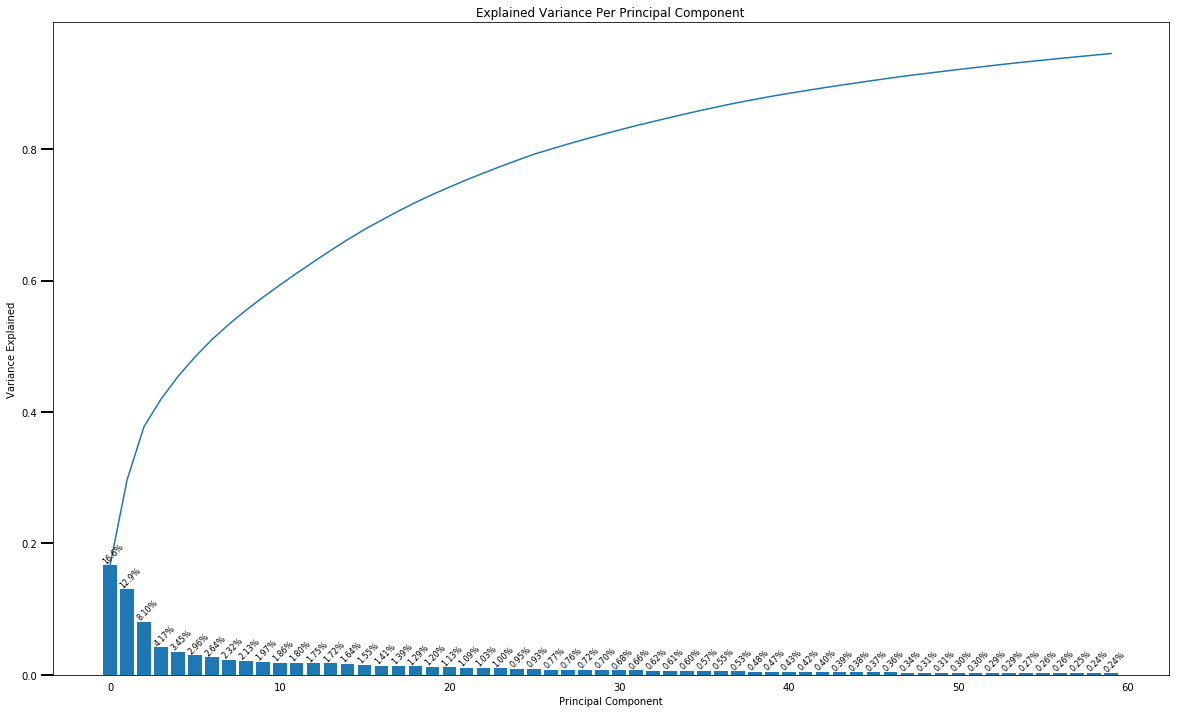

In [59]:
# Create Scree Plot
scree_plot(pca)

In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 4
pca = PCA(n_components)
azdias_pca = pca.fit_transform(azdias_final_standardized_imputed)

### Discussion 2.2: Perform Dimensionality Reduction

The first 60 PCA components are plotted. While the %variance explained increases as the no. of components increases, the curve starts to flatten after the 4rd component. Moreover, the first 4 components have already explained for more than 40% of the total variance. With the reducing marginal return when more components are chosen, here I selected 4 as the number of PCA components retained for further analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Labels are translated for convenience of interpretation
labels = pd.read_table('labels2.csv', delimiter = ',')

def interpret_pca(n_components, k):
    
    pca_int = PCA(n_components)
    azdias_pca = pca_int.fit_transform(azdias_final_standardized_imputed)
    
    df = pd.DataFrame(pca_int.components_, columns=labels['Translated'])
    df = df.transpose()

    for c in range(n_components):
        topk = df.sort_values(c, ascending=False).iloc[:k,c]
        bottomk = df.sort_values(c, ascending=False).iloc[-k:,c]
        print(f"Component{c+1}\n----------")
        for i,v in zip(topk.index, topk.values):
            print(f" {v:.4f}, {i}")
        print(" .\n .\n .")
        for i,v in zip(bottomk.index, bottomk.values):
            print(f"{v:.4f}, {i}") 
        print("\n\n")

In [62]:
interpret_pca(4,7)

Component1
----------
 0.2211, PLZ8_n_large_family_houses
 0.2145, RR4_wealthTy_upper2lower_class
 0.2139, PLZ8_n_xlarge_family_houses
 0.2108, RR4_Wealth_R
 0.1988, H_Estimated_Household_Income_R
 0.1978, Comm_Size_community
 0.1964, Post_density_of_households
 .
 .
 .
-0.1641, Post_distance2downtown
-0.1685, B_Distance_from_Sale
-0.2070, RR3_n_buildings_in_cell
-0.2108, P_Fintype_low_financial_interest
-0.2149, RR3_n_small_family_houses
-0.2199, PLZ8_n_small_family_houses
-0.2318, RR1_Movement_pattern_R



Component2
----------
 0.2644, P_Estimated_age
 0.2391, P_Fintype_Be_prepared
 0.2218, P_Personality_Event_oriented
 0.1867, P_Personality_Sensial_minded
 0.1671, P_Customer_Return_type_R_influenceable2determined
 0.1173, H_Likelihood_of_child_in_household
 0.1080, P_Fintype_Houseowner
 .
 .
 .
-0.2135, P_Fintype_Investor
-0.2314, P_Fintype_Inconspicious
-0.2324, P_Personality_Dutiful
-0.2363, P_Personality_Traditional_minded
-0.2425, P_Fintype_money_saver
-0.2517, P_Personality_Re

### Discussion 2.3: Interpret Principal Components

From the above items, the interpretation of PCA components are as below:

1. Component 1: <br>
Noticable weights on this latent feature are: large households within the region, high density and size of community, high movement pattern, low household and regional income with mostly lower working class, close to city center and sales point. In short, this could represent a dimension measuring '**Poor, congested and unstable living condition close to citycenter**'.<br>

2. Component 2:<br>
Noticable weights on this latent feature are: Older age people mostly influenced by older dominated movements, non-religiou and non-traditional personality, likely houseowners with children, financially more well-prepared, conservative customer return type. This could could represent a dimension measuring'**Financially well-positioned, non-traditional, matured and low return shopper**'.<br>

3. Component 3:<br>
Noticable weights on this latent feature are: Female, Dreamful, Social and family-minded, Cultural-minded, Non-dominant and non-combaive. This could represented a dimension measuring'**Social, cultural, and family orientation and feminine personality**'.<br>

4. Component 4:<br>
Noticable weights on this latent feature are: Members of Green Avantgrade, High household and regional income and purchasing power, High household density and community size in the region, close to urban area and high online affinity. ' This could represent a dimension measuring '**High-income metropolitan with high online affinity**'.<br>

In [63]:
dict_pca_component = {'Component1': 'Poor, congested and unstable living condition close to citycenter',
                      'Component2': 'Financially well-positioned, non-traditional, matured and low return shopper',
                      'Component3': 'Social, cultural, and family orientation and feminine personality',
                      'Component4': 'High-income metropolitan with high online affinity'}

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# parameters
score_list = []
silhouette_list = []
n_cluster = range(2,15)

# cluster test
# run k-means clustering on the data and...
# compute the average within-cluster distances.
for i in n_cluster:
    km = KMeans(i)
#   km = MiniBatchKMeans(i) For quick testing
    azdias_label = km.fit_predict(azdias_pca)
    score_list.append(-km.score(azdias_pca))
    silhouette_list.append(silhouette_score(azdias_pca, azdias_label, sample_size = 10000))

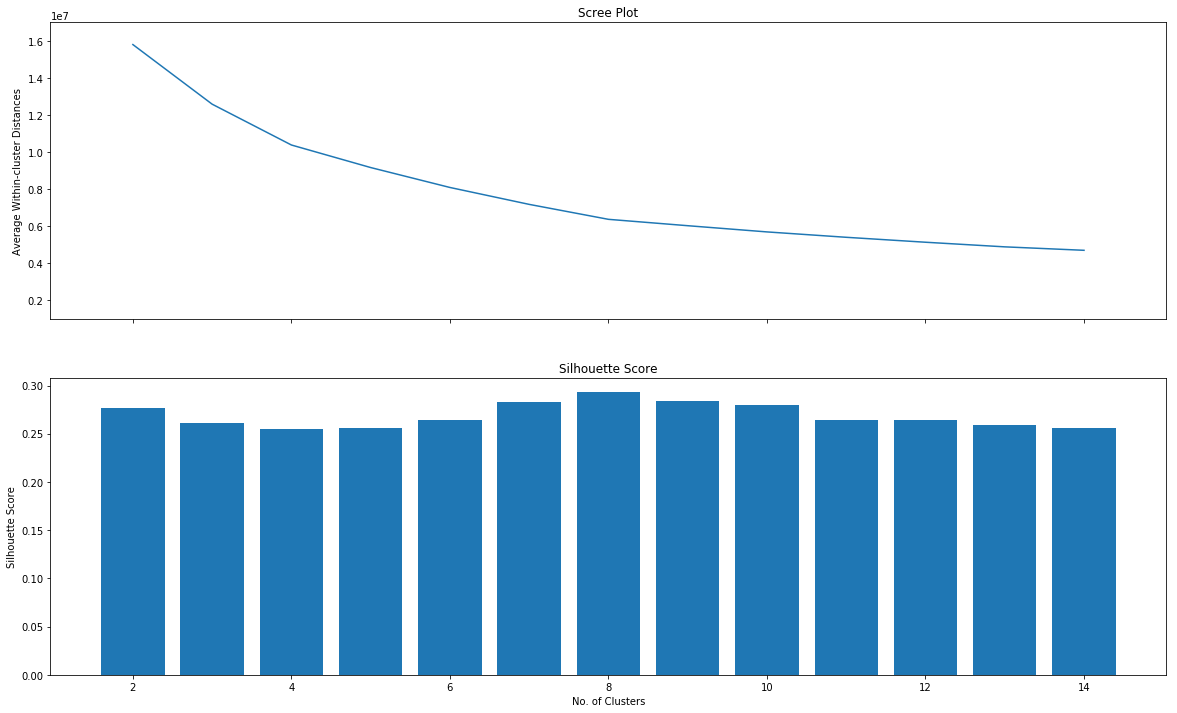

In [65]:
fig, axs = plt.subplots(2, sharex = True, figsize = (20,12))

axs[0].plot(list(n_cluster), score_list)
axs[0].set_ylim(1000000,17000000)
axs[0].set_title('Scree Plot')
axs[0].set_ylabel('Average Within-cluster Distances')

axs[1].bar(list(n_cluster), silhouette_list)
axs[1].set_title('Silhouette Score')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_xlabel('No. of Clusters')
axs[1].set_label('Silhouette score')

# 4 component, full-batch

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

km = KMeans(8) # Best Silhouette score
azdias_labels = km.fit_predict(azdias_pca);

### Discussion 3.1: Apply Clustering to General Population
The average within-cluster distances and Silhouette score were computed for cluster values from 2 to 14 using K-Means. <br>
There is a general trend of decreasing within-cluster distances but the marginal return of having more clusters decreases as well, while significantly increasing computation time. The Silhouette score tells us that above cluster number of 8, increasing number of clusters do not help creating more discrete clusters. <br>
Based on the values on the scree plot and the Silhouette score, 8 cluseters seem to be the optimal choice here.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

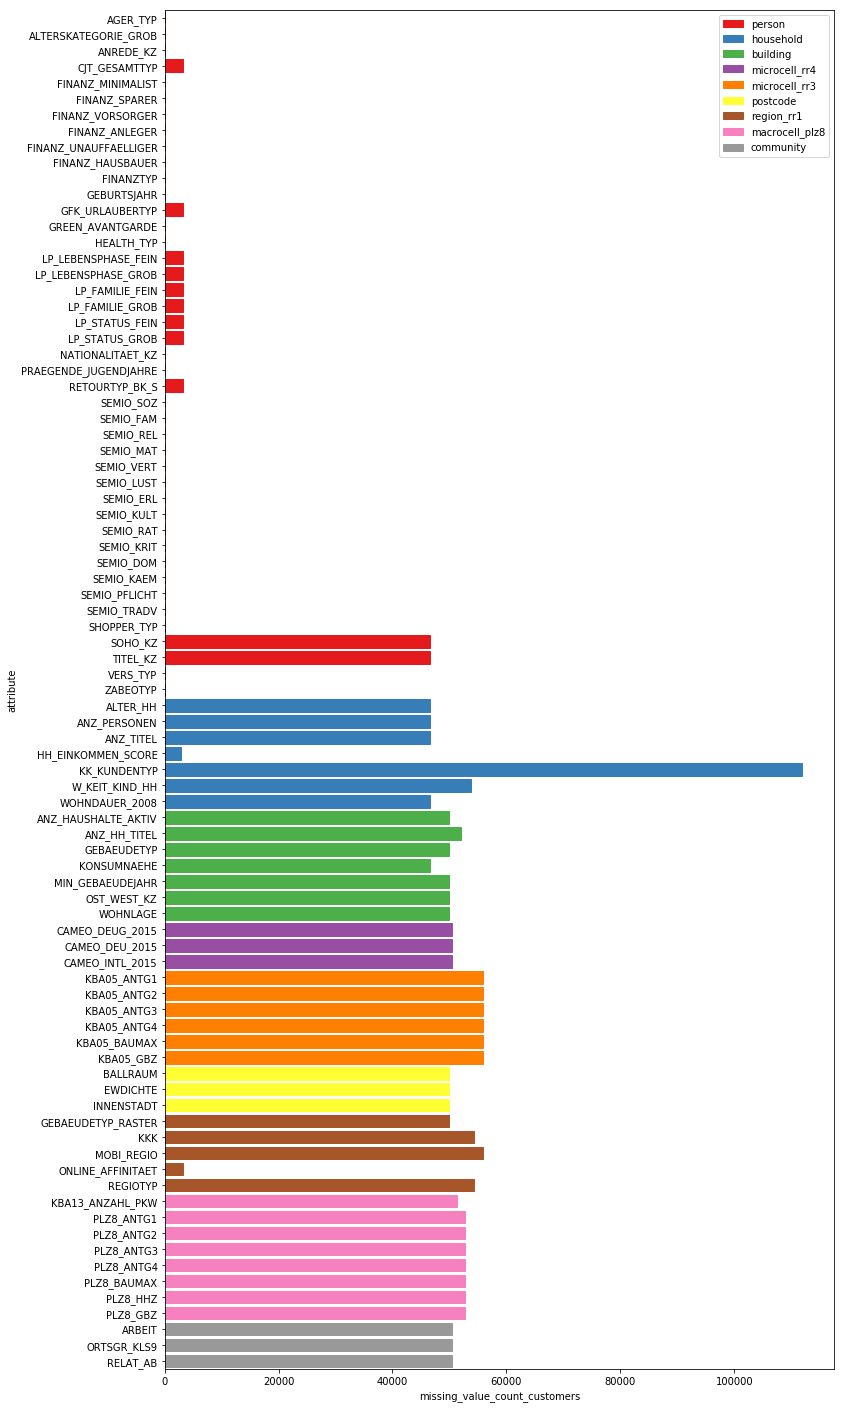

In [73]:
# check number of missing data by col
feat_info['missing_value_count_customers'] = customers.isnull().sum().values

# Plotting
plt.figure(figsize = (12,25));
barlist = sns.barplot(data = feat_info, y = 'attribute', x = 'missing_value_count_customers');

# Generate bar colours by information level
for i in range(n_features):
    barlist.get_children()[i].set_color(feat_info.loc[i,'information_level_color']) 

# Generate legends
idx,label = [],[]
for s in information_level:
    idx.append(barlist.get_children()[feat_info[feat_info['information_level'] == s].index[0]])
    label.append(s)
    
barlist.legend(idx,label);

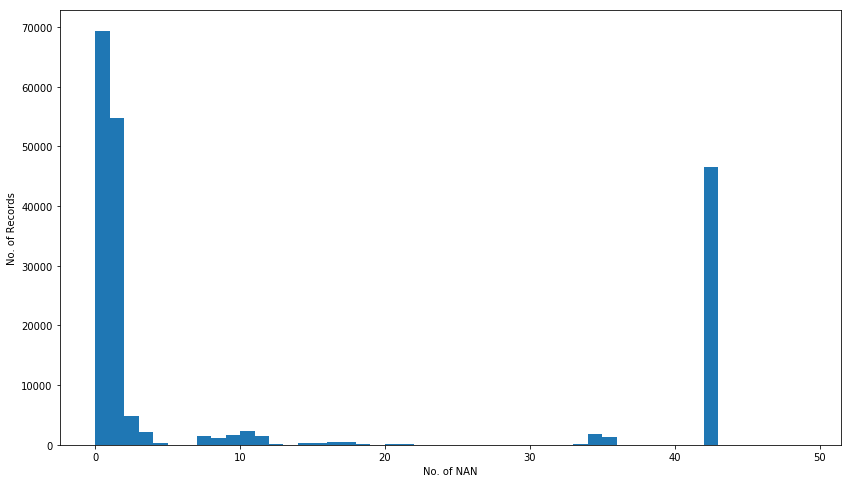

In [74]:
# check number of missing data by row
miss_by_row = customers.isnull().sum(axis=1)

plt.figure(figsize = (14,8))
plt.hist(miss_by_row, bins = range(50));
plt.xlabel('No. of NAN');
plt.ylabel('No. of Records');

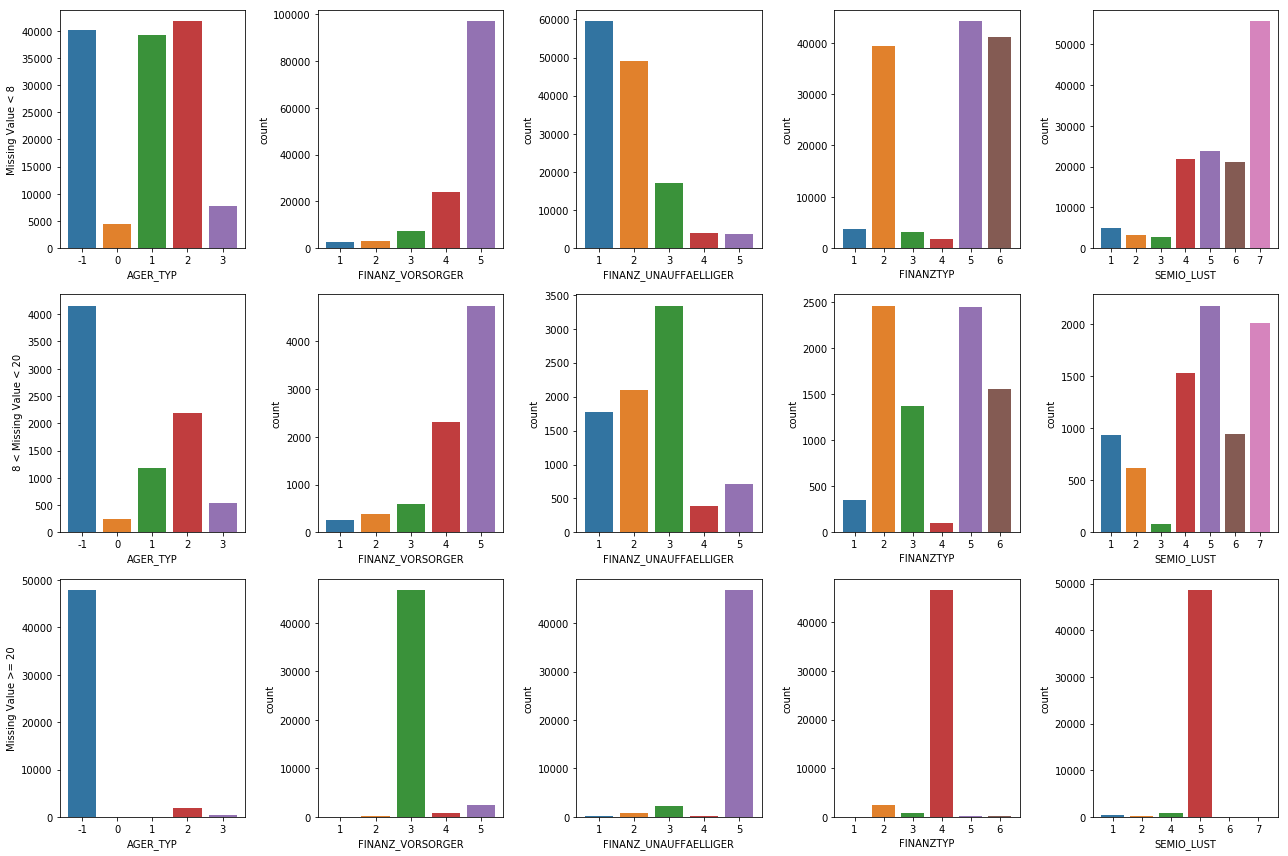

In [75]:
compare_nan_subsets(customers, ncol = 5, threshold = 20) 

### Handling of Missing Data in Customer Dataset
No. of missing data seemed to be higher for the customer data, with most information levels except personal containing around 25% of missing data. Similar to the Demographic data, there is a portion of data with more than 20 missing data by row. The above plot has, again, shown this subset of data could be noise or corrupted data as they are dominated by 1 particular value without showing any nomral distribution. These data will be excluded from the current analysis and revisited later.


In [86]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean data
customers_final = clean_data(customers)
# Seperate into discete and continuous subsets
customer_discrete = customers_final[col_discrete]
customer_continuous= customers_final[col_continuous]
# Standardize
customer_continuous_standardized, scalers = standardize(customer_continuous, fit=False, scalers=scalers)
customer_final_standardized = pd.concat([customer_discrete, customer_continuous], axis=1)[customers_final.columns]
# Impute NAN values
customer_final_standardized_imputed = imputer.transform(customer_final_standardized)
# PCA
customers_pca = pca.transform(customer_final_standardized_imputed)
# Clustering
customers_labels = km.predict(customers_pca)

No. of records: 191652, No. of features: 85
Columns removed: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
After removing the missing values: 
   No. of records: 141640, No, of features: 79


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


One-hot encoded feature [] was discarded due to <100 count.
No. of features after one-hot encoding and feature selection: 47
Final Data Structure after Feature Engineering, 
No. of records: 141640, No. of features:114


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# Adding back into the clusters the group with high proportion of missing data
n_azdias_miss = azdias.shape[0] - azdias_final.shape[0]
n_customer_miss = customers.shape[0] - customers_final.shape[0]

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



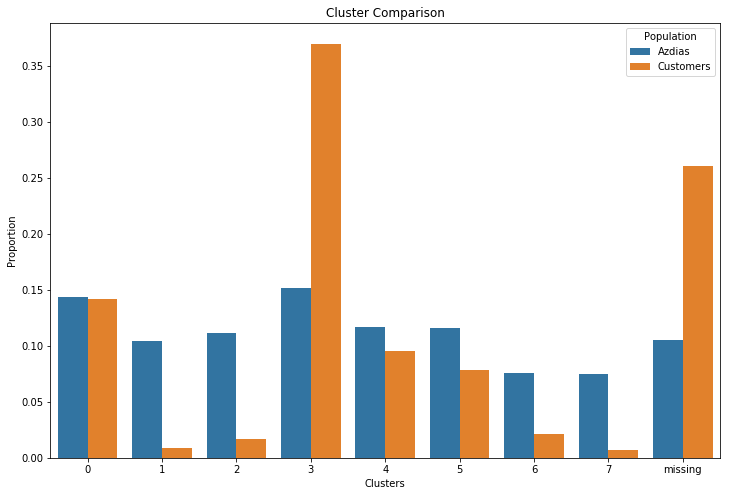

In [118]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Create Dataframe for plotting
azdias_clusters = pd.DataFrame(azdias_labels)[0].value_counts()
azdias_clusters = azdias_clusters.append(pd.Series({'missing': n_azdias_miss}))
customers_clusters = pd.DataFrame(customers_labels)[0].value_counts()
customers_clusters = customers_clusters.append(pd.Series({'missing': n_customer_miss}))

azdias_clusters_prop = pd.DataFrame(azdias_clusters/azdias.shape[0])
customers_clusters_prop = pd.DataFrame(customers_clusters/customers.shape[0])
clusters_prop = pd.concat([azdias_clusters_prop,customers_clusters_prop], axis = 1)
clusters_prop.reset_index(inplace = True)
clusters_prop.columns = ['Clusters','Azdias','Customers']
clusters_prop = clusters_prop.melt(id_vars = 'Clusters', var_name= 'Population', value_name='Proportion')

# Ploting
plt.figure(figsize=(12,8))
sns.barplot(x = 'Clusters', y = 'Proportion', data = clusters_prop, hue='Population')
plt.title('Cluster Comparison');

In [120]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Create Cluster Dataframe for interpretation
cluster_center = km.cluster_centers_
clusters = pca.inverse_transform(cluster_center)
df_cluster = pd.DataFrame(clusters, columns=labels['Translated']).transpose()

In [121]:
def interpret_cluster(df, cluster_no, k=5):
    
    topk = df.sort_values(cluster_no, ascending = False).iloc[:k,cluster_no]
    bottomk = df.sort_values(cluster_no,  ascending = False).iloc[-k:,cluster_no]
    
    print(f"Cluster{cluster_no}\n----------")
    
    print("PCA Components")
    for i,component in enumerate(cluster_center[cluster_no]):
        print(f"{component:.4f}, component{i+1}")
    
    print("\nQ-items")
    for i,v in zip(topk.index, topk.values):
        print(f" {v:.4f}, {i}")
    print(" .\n .\n .")
    for i,v in zip(bottomk.index, bottomk.values):
        print(f"{v:.4f}, {i}") 
    print("\n\n")

In [122]:
# Overrepresented Cluster (Target Customers)
interpret_cluster(df_cluster,3,7)

Cluster3
----------
PCA Components
-3.3856, component1
0.1850, component2
2.0556, component3
0.0914, component4

Q-items
 1.0698, P_Fintype_low_financial_interest
 0.9513, P_Nationality_German_nam
 0.8742, P_Personality_Dreamful
 0.7354, RR1_Movement_pattern_R
 0.7204, B_BuildTy_residential
 0.6931, RR3_n_small_family_houses
 0.6560, RR3_n_buildings_in_cell
 .
 .
 .
-0.6678, RR4_Wealth_R
-0.6812, RR4_wealthTy_upper2lower_class
-0.7110, P_Fintype_money_saver
-0.7357, H_Estimated_Household_Income_R
-0.7577, P_Personality_Rational
-0.7581, P_Personality_Dominant_minded
-0.8524, P_Personality_Combative_attitude





In [123]:
# Underrepresented Cluster
interpret_cluster(df_cluster,1,7)

Cluster1
----------
PCA Components
4.3308, component1
-1.2747, component2
-2.3181, component3
0.1152, component4

Q-items
 1.1239, P_Fintype_money_saver
 1.1030, P_Personality_Rational
 0.9540, P_Dominating_movement_youth_0main_1avant
 0.9413, P_Gender
 0.9410, P_Dominating_movement_Decade_old2new
 0.9339, P_Fintype_Investor
 0.9036, P_Personality_Dutiful
 .
 .
 .
-0.7699, PLZ8_n_small_family_houses
-0.7956, RR3_n_small_family_houses
-0.8490, RR1_Movement_pattern_R
-0.9503, P_Personality_Dreamful
-0.9536, P_Estimated_age
-0.9714, P_Fintype_Be_prepared
-1.3783, P_Fintype_low_financial_interest





### Discussion 3.3: Compare Customer Data to Demographics Data

From the above cluster analysis, Cluster 3 were popular with the mail-order company and should be the target audience. <br>
By looking at the PCA components, this group of people were highly negative on component 1, which is the opposite of **Poor, congested and unstable living condition close to citycenter** and a decent degree of **Social, cultural, and family orientation and feminine personality**. This could be high-income upperclass feamle living in the city. The demographic items mostly agrees with this with the additional information of this group of people having a German-sounded name.

Cluster 1 were the idividuals unpopular with the company. This group of people are characterized, throgh the PCA components, as high on component 1, which represents **Poor, congested and unstable living condition close to citycenter'** and negative degree of component 3, **Social, cultural, and family orientation and feminine personality** and a slighly negative  degree of opposite of component 2, **Financially well-positioned, non-traditional, matured and low return shopper**. Thus could represent a group of less financially prepared male, possibly the younger generation. The demographic items suggested that they are young, rational and money saver type.

Larger proportion of missing data were also seen in the customer dataset, which tell us that we still do not have the profile of a large amount of customers of the mail-order company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [92]:
dict_pca_component

{'Component1': 'Poor, congested and unstable living condition close to citycenter',
 'Component2': 'Financially well-positioned, non-traditional, matured and low return shopper',
 'Component3': 'Social, cultural, and family orientation and feminine personality',
 'Component4': 'High-income metropolitan with high online affinity'}